In [1]:
import os

import tifffile
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import wandb
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
from kmeans_pytorch import kmeans, kmeans_predict

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from dino_extended.data.utils import listfiles, extract_ome_tiff, get_ome_tiff_channels, make_pseudo
from dino_extended.data.multiplex import TileTransform, TileDataset, MultichannelAug
from dino_extended.models.dino import Dino
from dino_extended.models.vit import ViT, Recorder, Extractor

In [6]:
fps = sorted(listfiles(
    '/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_2/results',
    regex=r's[0-9]+.pt$'))
fps

['/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_2/results/s0.pt',
 '/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_2/results/s3.pt']

s0 torch.Size([20, 393, 387])


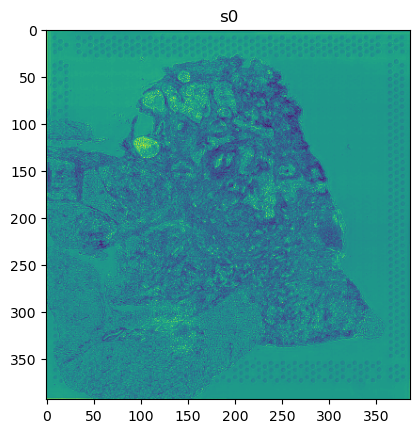

s3 torch.Size([20, 393, 387])


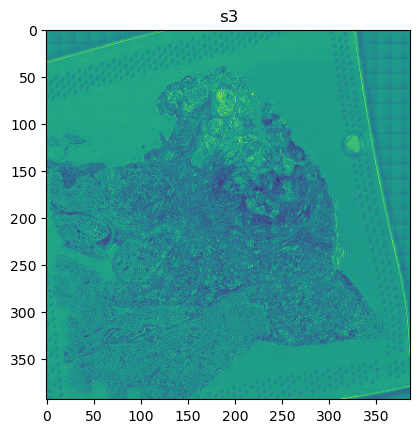

In [7]:
sid_to_metagene_img = {}
for fp in fps:
    sid = fp.split('/')[-1].split('.')[0]
    d = torch.load(fp)
    sid_to_metagene_img[sid] = d['metagene_activity']
for sid, img in sid_to_metagene_img.items():
    print(sid, img.shape)
    plt.imshow(img[0])
    plt.title(sid)
    plt.show()

In [8]:
sid_to_metagene_img['s0']

tensor([[[102, 122, 113,  ..., 109, 108, 108],
         [103, 122, 113,  ..., 125, 125, 125],
         [103, 122, 114,  ..., 108, 108, 108],
         ...,
         [112, 111, 111,  ..., 111, 112, 116],
         [111, 111, 110,  ..., 111, 112, 116],
         [124, 124, 124,  ..., 111, 112, 117]],

        [[103, 113, 112,  ..., 106, 106, 107],
         [102, 113, 112,  ...,  97,  97,  98],
         [102, 113, 112,  ..., 110, 110, 110],
         ...,
         [113, 112, 112,  ..., 115, 112, 106],
         [106, 105, 105,  ..., 115, 112, 105],
         [ 96,  96,  96,  ..., 114, 111, 105]],

        [[119, 133, 146,  ..., 130, 129, 128],
         [120, 134, 147,  ..., 142, 142, 141],
         [121, 134, 148,  ..., 135, 135, 135],
         ...,
         [136, 136, 135,  ..., 137, 132, 150],
         [133, 133, 132,  ..., 137, 132, 150],
         [141, 140, 139,  ..., 137, 132, 151]],

        ...,

        [[ 80, 105, 113,  ...,  74,  75,  75],
         [ 81, 106, 114,  ..., 101, 102, 101]

In [9]:
for sid, img in sid_to_metagene_img.items():
    img = img.to(torch.float32)
    img -= img.min()
    img /= img.max()
    sid_to_metagene_img[sid] = img
    

In [10]:
imgs = list(sid_to_metagene_img.values())

In [18]:
size = (256, 256)
scale = 16.
ds = TileDataset(imgs, size=size, scale=scale)

In [19]:
len(ds)

8192

In [20]:
tile = ds[0]
tile.shape

torch.Size([20, 256, 256])

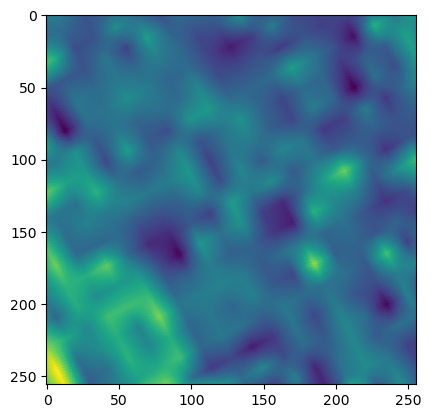

In [21]:
plt.imshow(tile[0])

In [22]:
means, stds = imgs[0].mean(dim=(-2, -1)), imgs[0].std(dim=(-2, -1))
means, stds

(tensor([0.4080, 0.4077, 0.5171, 0.4315, 0.4417, 0.4810, 0.4640, 0.4892, 0.3997,
         0.4904, 0.4358, 0.3953, 0.4768, 0.3806, 0.4087, 0.3853, 0.3939, 0.4238,
         0.4292, 0.4540]),
 tensor([0.0280, 0.0355, 0.0545, 0.0500, 0.0420, 0.0562, 0.0341, 0.0510, 0.0460,
         0.0457, 0.0406, 0.0171, 0.0507, 0.0414, 0.0264, 0.0758, 0.0562, 0.0552,
         0.0423, 0.0551]))

In [23]:
batch_size = 128
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=20)

In [24]:
b = next(iter(dl))
b.shape

torch.Size([128, 20, 256, 256])

In [25]:
n_image_channels = imgs[0].shape[0]
n_image_channels

20

In [26]:
from pathlib import Path
project = 'metagene_dino'
run_dir = f'/data/estorrs/DINO-extended/data/runs/HT397B1/{project}_v2'
log_dir = os.path.join(run_dir, 'logs')
chkpt_dir = os.path.join(run_dir, 'chkpts')
Path(log_dir).mkdir(parents=True, exist_ok=True)
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [27]:
run = wandb.init(
  project=project,
)

In [47]:
# wandb.finish()

In [28]:
config = {
    'epochs': 200,
    'lr': 3e-4,
    'batch_size': batch_size,
    'vit': {
        'image_size': size[0],
        'channels': n_image_channels,
        'patch_size': 32,
        'num_classes': 100,
        'dim': 1024,
        'depth': 6,
        'heads': 8,
        'mlp_dim': 2048
    },
    'dino': {
        'is_multichannel': True,
        'n_image_channels': n_image_channels,
        'scale': scale,
        'means': list(means.numpy()),
        'stds': list(stds.numpy()),
        'image_size': size[0],
        'hidden_layer': 'to_latent',
        'projection_hidden_size': 256,      # projector network hidden dimension
        'projection_layers': 4,             # number of layers in projection network
        'num_classes_K': 65336,             # output logits dimensions (referenced as K in paper)
        'student_temp': 0.9,                # student temperature
        'teacher_temp': 0.04,               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
        'local_upper_crop_scale': 0.4,      # upper bound for local crop - 0.4 was recommended in the paper 
        'global_lower_crop_scale': 0.5,     # lower bound for global crop - 0.5 was recommended in the paper
        'moving_average_decay': 0.9,        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
        'center_moving_average_decay': 0.9, # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
        'teacher_temps': list(np.linspace(.04, .07, 30))
    }
}

wandb.config = config

In [29]:
model = ViT(
    image_size = config['vit']['image_size'],
    channels = config['vit']['channels'],
    patch_size = config['vit']['patch_size'],
    num_classes = config['vit']['num_classes'],
    dim = config['vit']['dim'],
    depth = config['vit']['depth'],
    heads = config['vit']['heads'],
    mlp_dim = config['vit']['mlp_dim']
)

In [30]:
learner = Dino(
    model,
    is_multichannel=config['dino']['is_multichannel'],
    n_image_channels=config['dino']['n_image_channels'],
    means=config['dino']['means'],
    stds=config['dino']['stds'],
    image_size = config['dino']['image_size'],
    hidden_layer = config['dino']['hidden_layer'],        # hidden layer name or index, from which to extract the embedding
    projection_hidden_size = config['dino']['projection_hidden_size'],      # projector network hidden dimension
    projection_layers = config['dino']['projection_layers'],             # number of layers in projection network
    num_classes_K = config['dino']['num_classes_K'],             # output logits dimensions (referenced as K in paper)
    student_temp = config['dino']['student_temp'],                # student temperature
    teacher_temp = config['dino']['teacher_temp'],               # teacher temperature, needs to be annealed from 0.04 to 0.07 over 30 epochs
    local_upper_crop_scale = config['dino']['local_upper_crop_scale'],      # upper bound for local crop - 0.4 was recommended in the paper 
    global_lower_crop_scale = config['dino']['global_lower_crop_scale'],     # lower bound for global crop - 0.5 was recommended in the paper
    moving_average_decay = config['dino']['moving_average_decay'],        # moving average of encoder - paper showed anywhere from 0.9 to 0.999 was ok
    center_moving_average_decay = config['dino']['center_moving_average_decay'], # moving average of teacher centers - paper showed anywhere from 0.9 to 0.999 was ok
)

/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [31]:
def get_cluster_images(model, embeddings):
    x = embeddings[:, 1:]
    orig_shape = x.shape
    x = rearrange(x, 'b p d -> (b p) d')
    cluster_ids_x, cluster_centers = kmeans(
        X=x, num_clusters=10, tol=1., distance='euclidean', device=torch.device('cuda:0')
    )
    reshaped = rearrange(cluster_ids_x, '(b p) -> b p', p=orig_shape[1])
    img = rearrange(reshaped, 'b (h w) -> b h w', h=int(np.sqrt(orig_shape[1])))
    
    img = img.to(torch.float32)
    img -= img.min()
    img /= img.max()
    
    return img

def log_media(model, dl, n_show=16, n_batches=5):
    embeddings = []
    imgs = None
    v = Extractor(model)
    with torch.no_grad():
        for i, b in enumerate(dl):
            if i == n_batches:
                break
            b = b.to(0)
            _, embs = v(b)
            embeddings.append(embs)
            
            if imgs is None:
                imgs = b[:n_show, :1]
    
    embeddings = torch.concat(tuple(embeddings), dim=0)
    cluster_imgs = get_cluster_images(model, embeddings)[:n_show].unsqueeze(dim=1).numpy()
    cluster_imgs = rearrange(cluster_imgs, 'b c h w -> b h w c')
    
    metas = [np.expand_dims(img.detach().cpu().numpy(), 0) for img in imgs]
    metas = np.concatenate(metas, axis=0)
    
    wandb.log({
        'train/metagene_0': [wandb.Image(x) for x in metas],
        'train/clustered': [wandb.Image(x) for x in cluster_imgs]
    })
    
    v = v.eject()
    

    
    return cluster_imgs, metas

In [32]:
len(dl)

64

In [33]:
learner = learner.to(0)

In [34]:
teacher_temps = config['dino']['teacher_temps']
teacher_temps

[0.04,
 0.04103448275862069,
 0.04206896551724138,
 0.04310344827586207,
 0.04413793103448276,
 0.04517241379310345,
 0.04620689655172414,
 0.04724137931034483,
 0.04827586206896552,
 0.049310344827586214,
 0.0503448275862069,
 0.05137931034482759,
 0.05241379310344828,
 0.05344827586206897,
 0.05448275862068966,
 0.05551724137931035,
 0.05655172413793104,
 0.05758620689655173,
 0.05862068965517242,
 0.05965517241379311,
 0.0606896551724138,
 0.061724137931034484,
 0.06275862068965518,
 0.06379310344827586,
 0.06482758620689656,
 0.06586206896551725,
 0.06689655172413794,
 0.06793103448275863,
 0.06896551724137931,
 0.07]

In [35]:
epochs = config['epochs']
lr = config['lr']
opt = torch.optim.Adam(learner.parameters(), lr=lr)

In [36]:
media_log_every = 5
chkpt_every = 10

In [37]:
for e in range(epochs):
    epoch_loss = None
    for b in dl:
        b = b.to(0)
        loss = learner(b)
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of teacher encoder and teacher centers
        
        if epoch_loss is None:
            epoch_loss = loss.detach().cpu().item()
        else:
            epoch_loss += loss.detach().cpu().item()
    result = {"train/loss": epoch_loss / len(dl), 'n_steps': e * len(dl) * batch_size, 'epoch': e}
    print(result)
    wandb.log(result)
    if e % media_log_every == 0:
        log_media(model, dl)
    
    if e < 29:
        learner.teacher_temp = teacher_temps[e + 1]
        
    if e % chkpt_every == 0:
        torch.save(model.state_dict(), os.path.join(chkpt_dir, f'{e}.pt'))
    

{'train/loss': 10.94003726541996, 'n_steps': 0, 'epoch': 0}
running k-means on cuda:0..


[running kmeans]: 22it [00:14,  1.50it/s, center_shift=0.807237, iteration=22, tol=1.000000]   


{'train/loss': 10.476777821779251, 'n_steps': 8192, 'epoch': 1}
{'train/loss': 9.821413651108742, 'n_steps': 16384, 'epoch': 2}
{'train/loss': 9.040634214878082, 'n_steps': 24576, 'epoch': 3}
{'train/loss': 8.059864230453968, 'n_steps': 32768, 'epoch': 4}
{'train/loss': 6.8854202926158905, 'n_steps': 40960, 'epoch': 5}
running k-means on cuda:0..


[running kmeans]: 45it [00:29,  1.51it/s, center_shift=0.526076, iteration=45, tol=1.000000]   


{'train/loss': 5.91853541135788, 'n_steps': 49152, 'epoch': 6}
{'train/loss': 4.709808953106403, 'n_steps': 57344, 'epoch': 7}
{'train/loss': 3.5567762032151222, 'n_steps': 65536, 'epoch': 8}
{'train/loss': 2.8186910524964333, 'n_steps': 73728, 'epoch': 9}
{'train/loss': 2.357833657413721, 'n_steps': 81920, 'epoch': 10}
running k-means on cuda:0..


[running kmeans]: 66it [00:44,  1.49it/s, center_shift=0.307437, iteration=66, tol=1.000000]    


{'train/loss': 2.2309196181595325, 'n_steps': 90112, 'epoch': 11}
{'train/loss': 1.9918514154851437, 'n_steps': 98304, 'epoch': 12}
{'train/loss': 1.446879979223013, 'n_steps': 106496, 'epoch': 13}
{'train/loss': 1.0754797458648682, 'n_steps': 114688, 'epoch': 14}
{'train/loss': 0.9521046634763479, 'n_steps': 122880, 'epoch': 15}
running k-means on cuda:0..


[running kmeans]: 40it [00:26,  1.50it/s, center_shift=0.843837, iteration=40, tol=1.000000]    


{'train/loss': 0.7724005253985524, 'n_steps': 131072, 'epoch': 16}
{'train/loss': 0.6340901958756149, 'n_steps': 139264, 'epoch': 17}
{'train/loss': 0.5531129473820329, 'n_steps': 147456, 'epoch': 18}
{'train/loss': 0.5151816867291927, 'n_steps': 155648, 'epoch': 19}
{'train/loss': 0.42545852554030716, 'n_steps': 163840, 'epoch': 20}
running k-means on cuda:0..


[running kmeans]: 49it [00:32,  1.49it/s, center_shift=0.343533, iteration=49, tol=1.000000]    


{'train/loss': 0.38300737645477057, 'n_steps': 172032, 'epoch': 21}
{'train/loss': 0.4075461598113179, 'n_steps': 180224, 'epoch': 22}
{'train/loss': 0.35580050805583596, 'n_steps': 188416, 'epoch': 23}
{'train/loss': 0.32541601196862757, 'n_steps': 196608, 'epoch': 24}
{'train/loss': 0.371734929503873, 'n_steps': 204800, 'epoch': 25}
running k-means on cuda:0..


[running kmeans]: 30it [00:20,  1.49it/s, center_shift=0.738909, iteration=30, tol=1.000000]    


{'train/loss': 0.3165978090837598, 'n_steps': 212992, 'epoch': 26}
{'train/loss': 0.32994147622957826, 'n_steps': 221184, 'epoch': 27}
{'train/loss': 0.3187033690046519, 'n_steps': 229376, 'epoch': 28}
{'train/loss': 0.39502005092799664, 'n_steps': 237568, 'epoch': 29}
{'train/loss': 0.3320535128004849, 'n_steps': 245760, 'epoch': 30}
running k-means on cuda:0..


[running kmeans]: 45it [00:30,  1.49it/s, center_shift=0.448922, iteration=45, tol=1.000000]    


{'train/loss': 0.3151084058918059, 'n_steps': 253952, 'epoch': 31}
{'train/loss': 0.3756379031110555, 'n_steps': 262144, 'epoch': 32}
{'train/loss': 0.6152351535856724, 'n_steps': 270336, 'epoch': 33}
{'train/loss': 0.42271795752458274, 'n_steps': 278528, 'epoch': 34}
{'train/loss': 0.41530571319162846, 'n_steps': 286720, 'epoch': 35}
running k-means on cuda:0..


[running kmeans]: 78it [00:51,  1.50it/s, center_shift=0.913978, iteration=78, tol=1.000000]    


{'train/loss': 0.4565865080803633, 'n_steps': 294912, 'epoch': 36}
{'train/loss': 0.8666875348426402, 'n_steps': 303104, 'epoch': 37}
{'train/loss': 2.2894134540110826, 'n_steps': 311296, 'epoch': 38}
{'train/loss': 1.6026804484426975, 'n_steps': 319488, 'epoch': 39}
{'train/loss': 2.244032479589805, 'n_steps': 327680, 'epoch': 40}
running k-means on cuda:0..


[running kmeans]: 23it [00:15,  1.49it/s, center_shift=0.541996, iteration=23, tol=1.000000]    


{'train/loss': 3.7110097954282537, 'n_steps': 335872, 'epoch': 41}
{'train/loss': 4.97037732321769, 'n_steps': 344064, 'epoch': 42}
{'train/loss': 3.2184930089861155, 'n_steps': 352256, 'epoch': 43}
{'train/loss': 3.6923920530825853, 'n_steps': 360448, 'epoch': 44}
{'train/loss': 2.8218812458217144, 'n_steps': 368640, 'epoch': 45}
running k-means on cuda:0..


[running kmeans]: 69it [00:46,  1.49it/s, center_shift=0.831388, iteration=69, tol=1.000000]    


{'train/loss': 2.5668691750615835, 'n_steps': 376832, 'epoch': 46}
{'train/loss': 2.446165282279253, 'n_steps': 385024, 'epoch': 47}
{'train/loss': 1.7883834596723318, 'n_steps': 393216, 'epoch': 48}
{'train/loss': 1.5007385509088635, 'n_steps': 401408, 'epoch': 49}
{'train/loss': 1.0190926739014685, 'n_steps': 409600, 'epoch': 50}
running k-means on cuda:0..


[running kmeans]: 24it [00:16,  1.49it/s, center_shift=0.583965, iteration=24, tol=1.000000]    


{'train/loss': 0.6328889345750213, 'n_steps': 417792, 'epoch': 51}
{'train/loss': 0.6607234794646502, 'n_steps': 425984, 'epoch': 52}
{'train/loss': 0.8497495511546731, 'n_steps': 434176, 'epoch': 53}
{'train/loss': 0.37904505687765777, 'n_steps': 442368, 'epoch': 54}
{'train/loss': 0.3759172852151096, 'n_steps': 450560, 'epoch': 55}
running k-means on cuda:0..


[running kmeans]: 24it [00:16,  1.48it/s, center_shift=0.162080, iteration=24, tol=1.000000]    


{'train/loss': 0.362630111631006, 'n_steps': 458752, 'epoch': 56}
{'train/loss': 0.4005109956488013, 'n_steps': 466944, 'epoch': 57}
{'train/loss': 0.3444275588262826, 'n_steps': 475136, 'epoch': 58}
{'train/loss': 0.3665843366179615, 'n_steps': 483328, 'epoch': 59}
{'train/loss': 0.32458628294989467, 'n_steps': 491520, 'epoch': 60}
running k-means on cuda:0..


[running kmeans]: 16it [00:10,  1.49it/s, center_shift=0.624294, iteration=16, tol=1.000000]    


{'train/loss': 0.35139093012548983, 'n_steps': 499712, 'epoch': 61}
{'train/loss': 0.3778145075775683, 'n_steps': 507904, 'epoch': 62}
{'train/loss': 0.335986947407946, 'n_steps': 516096, 'epoch': 63}
{'train/loss': 0.3486358218360692, 'n_steps': 524288, 'epoch': 64}
{'train/loss': 0.3925796071998775, 'n_steps': 532480, 'epoch': 65}
running k-means on cuda:0..


[running kmeans]: 45it [00:30,  1.49it/s, center_shift=0.779178, iteration=45, tol=1.000000]    


{'train/loss': 0.35984622361138463, 'n_steps': 540672, 'epoch': 66}
{'train/loss': 0.3197471883613616, 'n_steps': 548864, 'epoch': 67}
{'train/loss': 0.33026579790748656, 'n_steps': 557056, 'epoch': 68}
{'train/loss': 0.311947881244123, 'n_steps': 565248, 'epoch': 69}
{'train/loss': 0.34893761249259114, 'n_steps': 573440, 'epoch': 70}
running k-means on cuda:0..


[running kmeans]: 119it [01:20,  1.49it/s, center_shift=0.950218, iteration=119, tol=1.000000]   


{'train/loss': 0.316060493234545, 'n_steps': 581632, 'epoch': 71}
{'train/loss': 0.33124112826772034, 'n_steps': 589824, 'epoch': 72}
{'train/loss': 0.32600446604192257, 'n_steps': 598016, 'epoch': 73}
{'train/loss': 0.3171283625997603, 'n_steps': 606208, 'epoch': 74}
{'train/loss': 0.3153841579332948, 'n_steps': 614400, 'epoch': 75}
running k-means on cuda:0..


[running kmeans]: 31it [00:21,  1.44it/s, center_shift=0.474317, iteration=31, tol=1.000000]    


{'train/loss': 0.31464127101935446, 'n_steps': 622592, 'epoch': 76}
{'train/loss': 0.3457828641985543, 'n_steps': 630784, 'epoch': 77}
{'train/loss': 0.36960268556140363, 'n_steps': 638976, 'epoch': 78}
{'train/loss': 0.5118133595678955, 'n_steps': 647168, 'epoch': 79}
{'train/loss': 0.3677680443506688, 'n_steps': 655360, 'epoch': 80}
running k-means on cuda:0..


[running kmeans]: 94it [01:03,  1.49it/s, center_shift=0.440683, iteration=94, tol=1.000000]    


{'train/loss': 0.33381376322358847, 'n_steps': 663552, 'epoch': 81}
{'train/loss': 0.4246574118733406, 'n_steps': 671744, 'epoch': 82}
{'train/loss': 0.41884319321252406, 'n_steps': 679936, 'epoch': 83}
{'train/loss': 0.3327274296898395, 'n_steps': 688128, 'epoch': 84}
{'train/loss': 0.3216595300473273, 'n_steps': 696320, 'epoch': 85}
running k-means on cuda:0..


[running kmeans]: 62it [00:41,  1.49it/s, center_shift=0.382533, iteration=62, tol=1.000000]    


{'train/loss': 0.31069954205304384, 'n_steps': 704512, 'epoch': 86}
{'train/loss': 0.3196101416833699, 'n_steps': 712704, 'epoch': 87}
{'train/loss': 0.34666723012924194, 'n_steps': 720896, 'epoch': 88}
{'train/loss': 0.3595948733855039, 'n_steps': 729088, 'epoch': 89}
{'train/loss': 0.36361149011645466, 'n_steps': 737280, 'epoch': 90}
running k-means on cuda:0..


[running kmeans]: 45it [00:30,  1.49it/s, center_shift=0.983727, iteration=45, tol=1.000000]    


{'train/loss': 0.3025839807232842, 'n_steps': 745472, 'epoch': 91}
{'train/loss': 0.34422731725499034, 'n_steps': 753664, 'epoch': 92}
{'train/loss': 0.3218996748328209, 'n_steps': 761856, 'epoch': 93}
{'train/loss': 0.36724511720240116, 'n_steps': 770048, 'epoch': 94}
{'train/loss': 0.2977414906490594, 'n_steps': 778240, 'epoch': 95}
running k-means on cuda:0..


[running kmeans]: 46it [00:30,  1.49it/s, center_shift=0.185138, iteration=46, tol=1.000000]    


{'train/loss': 0.31573217269033194, 'n_steps': 786432, 'epoch': 96}
{'train/loss': 0.3177547277882695, 'n_steps': 794624, 'epoch': 97}
{'train/loss': 0.34064800769556314, 'n_steps': 802816, 'epoch': 98}
{'train/loss': 0.30778405792079866, 'n_steps': 811008, 'epoch': 99}
{'train/loss': 0.3235020488500595, 'n_steps': 819200, 'epoch': 100}
running k-means on cuda:0..


[running kmeans]: 70it [00:46,  1.49it/s, center_shift=0.247605, iteration=70, tol=1.000000]     


{'train/loss': 0.3777335602790117, 'n_steps': 827392, 'epoch': 101}
{'train/loss': 0.3556373151950538, 'n_steps': 835584, 'epoch': 102}
{'train/loss': 0.3276112488238141, 'n_steps': 843776, 'epoch': 103}
{'train/loss': 0.33298616483807564, 'n_steps': 851968, 'epoch': 104}
{'train/loss': 0.3104204803239554, 'n_steps': 860160, 'epoch': 105}
running k-means on cuda:0..


[running kmeans]: 52it [00:34,  1.50it/s, center_shift=0.655342, iteration=52, tol=1.000000]     


{'train/loss': 0.38718890538439155, 'n_steps': 868352, 'epoch': 106}
{'train/loss': 0.3405969957821071, 'n_steps': 876544, 'epoch': 107}
{'train/loss': 0.3399584183935076, 'n_steps': 884736, 'epoch': 108}
{'train/loss': 0.31493511074222624, 'n_steps': 892928, 'epoch': 109}
{'train/loss': 0.47096028935629874, 'n_steps': 901120, 'epoch': 110}
running k-means on cuda:0..


[running kmeans]: 79it [00:52,  1.50it/s, center_shift=0.123423, iteration=79, tol=1.000000]     


{'train/loss': 4.065473740454763, 'n_steps': 909312, 'epoch': 111}
{'train/loss': 4.350144099444151, 'n_steps': 917504, 'epoch': 112}
{'train/loss': 3.9333479702472687, 'n_steps': 925696, 'epoch': 113}
{'train/loss': 2.9409377221018076, 'n_steps': 933888, 'epoch': 114}
{'train/loss': 1.3755468800663948, 'n_steps': 942080, 'epoch': 115}
running k-means on cuda:0..


[running kmeans]: 42it [00:28,  1.50it/s, center_shift=0.351625, iteration=42, tol=1.000000]    


{'train/loss': 0.7919679069891572, 'n_steps': 950272, 'epoch': 116}
{'train/loss': 0.5985699254088104, 'n_steps': 958464, 'epoch': 117}
{'train/loss': 0.4253637413494289, 'n_steps': 966656, 'epoch': 118}
{'train/loss': 0.4007532144896686, 'n_steps': 974848, 'epoch': 119}
{'train/loss': 0.3732836071867496, 'n_steps': 983040, 'epoch': 120}
running k-means on cuda:0..


[running kmeans]: 57it [00:38,  1.50it/s, center_shift=0.584687, iteration=57, tol=1.000000]     


{'train/loss': 0.4430060014128685, 'n_steps': 991232, 'epoch': 121}
{'train/loss': 0.38648653868585825, 'n_steps': 999424, 'epoch': 122}
{'train/loss': 0.3582064068177715, 'n_steps': 1007616, 'epoch': 123}
{'train/loss': 0.43057164759375155, 'n_steps': 1015808, 'epoch': 124}
{'train/loss': 0.3606397395487875, 'n_steps': 1024000, 'epoch': 125}
running k-means on cuda:0..


[running kmeans]: 33it [00:22,  1.47it/s, center_shift=0.985358, iteration=33, tol=1.000000]    


{'train/loss': 0.3831166081363335, 'n_steps': 1032192, 'epoch': 126}
{'train/loss': 0.37585734599269927, 'n_steps': 1040384, 'epoch': 127}
{'train/loss': 0.4895361242815852, 'n_steps': 1048576, 'epoch': 128}
{'train/loss': 1.9213865511119366, 'n_steps': 1056768, 'epoch': 129}
{'train/loss': 2.5908431317657232, 'n_steps': 1064960, 'epoch': 130}
running k-means on cuda:0..


[running kmeans]: 55it [00:36,  1.50it/s, center_shift=0.312271, iteration=55, tol=1.000000]     


{'train/loss': 1.5951641090214252, 'n_steps': 1073152, 'epoch': 131}
{'train/loss': 0.8679266953840852, 'n_steps': 1081344, 'epoch': 132}
{'train/loss': 0.5612484118901193, 'n_steps': 1089536, 'epoch': 133}
{'train/loss': 0.6147683397866786, 'n_steps': 1097728, 'epoch': 134}
{'train/loss': 0.6941123954020441, 'n_steps': 1105920, 'epoch': 135}
running k-means on cuda:0..


[running kmeans]: 123it [01:22,  1.50it/s, center_shift=0.377606, iteration=123, tol=1.000000]   


{'train/loss': 2.2491754898801446, 'n_steps': 1114112, 'epoch': 136}
{'train/loss': 4.027563028037548, 'n_steps': 1122304, 'epoch': 137}
{'train/loss': 3.433438565582037, 'n_steps': 1130496, 'epoch': 138}
{'train/loss': 3.1242387983947992, 'n_steps': 1138688, 'epoch': 139}
{'train/loss': 2.6227926947176456, 'n_steps': 1146880, 'epoch': 140}
running k-means on cuda:0..


[running kmeans]: 20it [00:13,  1.49it/s, center_shift=0.910849, iteration=20, tol=1.000000]     


{'train/loss': 2.127841217443347, 'n_steps': 1155072, 'epoch': 141}
{'train/loss': 1.3091387432068586, 'n_steps': 1163264, 'epoch': 142}
{'train/loss': 0.8415490156039596, 'n_steps': 1171456, 'epoch': 143}
{'train/loss': 0.6251662760041654, 'n_steps': 1179648, 'epoch': 144}
{'train/loss': 0.5011262642219663, 'n_steps': 1187840, 'epoch': 145}
running k-means on cuda:0..


[running kmeans]: 31it [00:20,  1.48it/s, center_shift=0.040556, iteration=31, tol=1.000000]    


{'train/loss': 0.4436026234179735, 'n_steps': 1196032, 'epoch': 146}
{'train/loss': 0.46975691709667444, 'n_steps': 1204224, 'epoch': 147}
{'train/loss': 0.5064154739957303, 'n_steps': 1212416, 'epoch': 148}
{'train/loss': 0.44012229470536113, 'n_steps': 1220608, 'epoch': 149}
{'train/loss': 0.4430587152019143, 'n_steps': 1228800, 'epoch': 150}
running k-means on cuda:0..


[running kmeans]: 49it [00:32,  1.50it/s, center_shift=0.814655, iteration=49, tol=1.000000]    


{'train/loss': 0.4541924190707505, 'n_steps': 1236992, 'epoch': 151}
{'train/loss': 0.41743267979472876, 'n_steps': 1245184, 'epoch': 152}
{'train/loss': 0.3852322679013014, 'n_steps': 1253376, 'epoch': 153}
{'train/loss': 0.34876293665729463, 'n_steps': 1261568, 'epoch': 154}
{'train/loss': 0.4592200592160225, 'n_steps': 1269760, 'epoch': 155}
running k-means on cuda:0..


[running kmeans]: 92it [01:01,  1.50it/s, center_shift=0.511868, iteration=92, tol=1.000000]     


{'train/loss': 0.4025086697656661, 'n_steps': 1277952, 'epoch': 156}
{'train/loss': 0.4016472806688398, 'n_steps': 1286144, 'epoch': 157}
{'train/loss': 0.39755728654563427, 'n_steps': 1294336, 'epoch': 158}
{'train/loss': 0.444805950159207, 'n_steps': 1302528, 'epoch': 159}
{'train/loss': 0.3927133549004793, 'n_steps': 1310720, 'epoch': 160}
running k-means on cuda:0..


[running kmeans]: 52it [00:35,  1.48it/s, center_shift=0.289358, iteration=52, tol=1.000000]    


{'train/loss': 0.3936898137908429, 'n_steps': 1318912, 'epoch': 161}
{'train/loss': 0.40271042939275503, 'n_steps': 1327104, 'epoch': 162}
{'train/loss': 0.36607361352071166, 'n_steps': 1335296, 'epoch': 163}
{'train/loss': 0.3759632429573685, 'n_steps': 1343488, 'epoch': 164}
{'train/loss': 0.3698498822050169, 'n_steps': 1351680, 'epoch': 165}
running k-means on cuda:0..


[running kmeans]: 38it [00:25,  1.50it/s, center_shift=0.355133, iteration=38, tol=1.000000]     


{'train/loss': 0.38116107950918376, 'n_steps': 1359872, 'epoch': 166}
{'train/loss': 0.46005871053785086, 'n_steps': 1368064, 'epoch': 167}
{'train/loss': 0.3704623889643699, 'n_steps': 1376256, 'epoch': 168}
{'train/loss': 0.404635832644999, 'n_steps': 1384448, 'epoch': 169}
{'train/loss': 0.39740181202068925, 'n_steps': 1392640, 'epoch': 170}
running k-means on cuda:0..


[running kmeans]: 64it [00:42,  1.49it/s, center_shift=0.201258, iteration=64, tol=1.000000]     


{'train/loss': 0.37710227095521986, 'n_steps': 1400832, 'epoch': 171}
{'train/loss': 0.3726052991114557, 'n_steps': 1409024, 'epoch': 172}
{'train/loss': 0.3526944855693728, 'n_steps': 1417216, 'epoch': 173}
{'train/loss': 0.3621646068058908, 'n_steps': 1425408, 'epoch': 174}
{'train/loss': 0.3873190700542182, 'n_steps': 1433600, 'epoch': 175}
running k-means on cuda:0..


[running kmeans]: 30it [00:20,  1.48it/s, center_shift=0.712470, iteration=30, tol=1.000000]    


{'train/loss': 0.35785525245592, 'n_steps': 1441792, 'epoch': 176}
{'train/loss': 0.39827947632875293, 'n_steps': 1449984, 'epoch': 177}
{'train/loss': 0.46727275964803994, 'n_steps': 1458176, 'epoch': 178}
{'train/loss': 0.4850987112149596, 'n_steps': 1466368, 'epoch': 179}
{'train/loss': 0.42071982845664024, 'n_steps': 1474560, 'epoch': 180}
running k-means on cuda:0..


[running kmeans]: 52it [00:34,  1.50it/s, center_shift=0.810183, iteration=52, tol=1.000000]    


{'train/loss': 0.4418588054832071, 'n_steps': 1482752, 'epoch': 181}
{'train/loss': 0.5560855551157147, 'n_steps': 1490944, 'epoch': 182}
{'train/loss': 0.4762222624849528, 'n_steps': 1499136, 'epoch': 183}
{'train/loss': 0.49761360115371644, 'n_steps': 1507328, 'epoch': 184}
{'train/loss': 0.5020419708453119, 'n_steps': 1515520, 'epoch': 185}
running k-means on cuda:0..


[running kmeans]: 48it [00:32,  1.49it/s, center_shift=0.000000, iteration=48, tol=1.000000]     


{'train/loss': 0.46671766485087574, 'n_steps': 1523712, 'epoch': 186}
{'train/loss': 0.48211659607477486, 'n_steps': 1531904, 'epoch': 187}
{'train/loss': 0.5100436587817967, 'n_steps': 1540096, 'epoch': 188}
{'train/loss': 2.4206623723730445, 'n_steps': 1548288, 'epoch': 189}
{'train/loss': 3.56233624368906, 'n_steps': 1556480, 'epoch': 190}
running k-means on cuda:0..


[running kmeans]: 53it [00:36,  1.45it/s, center_shift=0.521293, iteration=53, tol=1.000000]     


{'train/loss': 3.161196555942297, 'n_steps': 1564672, 'epoch': 191}
{'train/loss': 2.791719112545252, 'n_steps': 1572864, 'epoch': 192}
{'train/loss': 2.4519912507385015, 'n_steps': 1581056, 'epoch': 193}
{'train/loss': 1.9456315487623215, 'n_steps': 1589248, 'epoch': 194}
{'train/loss': 1.6251735463738441, 'n_steps': 1597440, 'epoch': 195}
running k-means on cuda:0..


[running kmeans]: 42it [00:28,  1.49it/s, center_shift=0.000000, iteration=42, tol=1.000000]     


{'train/loss': 2.344184458255768, 'n_steps': 1605632, 'epoch': 196}
{'train/loss': 2.490475919097662, 'n_steps': 1613824, 'epoch': 197}
{'train/loss': 2.386669646948576, 'n_steps': 1622016, 'epoch': 198}
{'train/loss': 2.20636323094368, 'n_steps': 1630208, 'epoch': 199}


wandb: Network error (ReadTimeout), entering retry loop.


In [38]:
best = ViT(
    image_size = config['vit']['image_size'],
    channels = config['vit']['channels'],
    patch_size = config['vit']['patch_size'],
    num_classes = config['vit']['num_classes'],
    dim = config['vit']['dim'],
    depth = config['vit']['depth'],
    heads = config['vit']['heads'],
    mlp_dim = config['vit']['mlp_dim']
)
best.load_state_dict(
    torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/chkpts/90.pt'))
best.eval()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((20480,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=20480, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=1024, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, eleme

In [39]:
# x = torch.rand(4, n_image_channels, 256, 256)
# out = best(x)

In [40]:
class TiledInferenceDataset(Dataset):
    def __init__(self, img, size=256, scale=.5, overlap_pct=.5, out_size=16):
        self.scale = scale
        self.size = size
        self.out_size = out_size
        self.overlap_pct = overlap_pct
        self.step_size = int(size * overlap_pct)
        self.tile_width = size

        self.full_res_shape = img.shape
        img = TF.resize(img, (int(img.shape[-2] * scale), int(img.shape[-1] * scale)))

        self.scaled_img_shape = img.shape
        
        self.padding = 0

        img = TF.pad(img, self.padding, padding_mode='reflect')
        self.img = img

        n_steps_width = self.img.shape[-1] // self.step_size
        n_steps_height = self.img.shape[-2] // self.step_size # assuming square tile
        self.coord_to_tile = {}
        self.coords = []
        self.absolute_coords = []
        for i in range(n_steps_height):
            for j in range(n_steps_width):
                r, c = i * self.step_size, j * self.step_size
                tile = TF.crop(self.img, r, c, self.tile_width, self.tile_width)
                self.coord_to_tile[(i, j)] = tile
                self.coords.append((i, j))
                self.absolute_coords.append((r, c))

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        i, j = self.coords[idx]
        r, c = self.absolute_coords[idx]
        tile = self.coord_to_tile[(i, j)]

        return {
            'coord': torch.tensor([i, j], dtype=torch.long),
            'absolute': torch.tensor([r, c], dtype=torch.long),
            'tile': tile,
        }
    
    def retile(self, coord_to_tile, trim_to_original=True, scale_to_original=False):
        tile = next(iter(coord_to_tile.values()))
        max_i = max([i for i, _ in coord_to_tile.keys()])
        max_j = max([j for _, j in coord_to_tile.keys()])
        new = None
        for i in range(max_i):
            row = None
            for j in range(max_j):
                tile = coord_to_tile[i, j]
                tile = TF.center_crop(
                    tile,
                    (int(self.out_size * self.overlap_pct), int(self.out_size * self.overlap_pct)))
                if row is None:
                    row = tile
                else:
                    row = torch.concat((row, tile), dim=-1)
            if new is None:
                new = row
            else:
                new = torch.concat((new, row), dim=-2)
        if trim_to_original:
            ratio = self.out_size / self.size
            h = int(self.scaled_img_shape[-2] * ratio)
            w = int(self.scaled_img_shape[-1] * ratio)
            new = new[..., :h, :w]
        if scale_to_original:
            new = TF.resize(new, (self.full_res_img_shape[-2], self.full_res_img_shape[-1]))

        return new

In [41]:
for img in imgs:
    print(img.shape)

torch.Size([20, 393, 387])
torch.Size([20, 393, 387])


In [47]:
n_clusters = 50
sample_to_embs = {}
for k, img in sid_to_metagene_img.items():
    print(k)
    normalized = TF.normalize(img, config['dino']['means'], config['dino']['stds'])
    ds = TiledInferenceDataset(
                normalized, size=config['dino']['image_size'], scale=config['dino']['scale'],
                out_size=config['vit']['image_size'] // config['vit']['patch_size']
        )
    dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=10)
    
    embeddings = []
    v = Extractor(best)
    with torch.no_grad():
        for b in dl:
            x = b['tile']
            _, embs = v(x)
            embeddings.append(embs)
    embeddings = torch.concat(tuple(embeddings), dim=0) # b patches d
    print(embeddings.shape)
    embeddings = embeddings[:, 1:] # get rid of cls token
    embeddings = rearrange(embeddings, 'b (ph pw) d -> b d ph pw', ph=ds.out_size)
    print(embeddings.shape)

    coord_to_tile = {k:v for k, v in zip(dl.dataset.coords, embeddings)}
    recon_embs = dl.dataset.retile(coord_to_tile, trim_to_original=False) # (d h w)
    
    x = rearrange(recon_embs, 'd h w -> (h w) d')
    cluster_ids_x, cluster_centers = kmeans(
        X=x, num_clusters=n_clusters, tol=10000., distance='euclidean', device=torch.device('cuda:0')
    )
    reshaped = rearrange(cluster_ids_x, '(ph pw) -> ph pw', ph=recon_embs.shape[-2])
    
    sample_to_embs[k] = {
        'clustered_patches': reshaped,
        'patch_centroids': cluster_centers,
        'patch_embs': recon_embs,
    }

s0
torch.Size([2352, 65, 1024])
torch.Size([2352, 1024, 8, 8])
running k-means on cuda:0..


[running kmeans]: 27it [01:28,  3.28s/it, center_shift=4661.897949, iteration=27, tol=10000.000000]  


s3
torch.Size([2352, 65, 1024])
torch.Size([2352, 1024, 8, 8])
running k-means on cuda:0..


[running kmeans]: 42it [02:18,  3.30s/it, center_shift=7593.080566, iteration=42, tol=10000.000000]  


In [48]:
# n_clusters = 100

# order = sorted(sample_to_embs.keys())

# combined = torch.concat([sample_to_embs[o].unsqueeze(0) for o in order], dim=0)
# x = rearrange(combined, 'b d h w -> (b h w) d')
# small = x[torch.randperm(len(x))[:10000]]
# cluster_ids_x, cluster_centers = kmeans(
#     X=small, num_clusters=n_clusters, tol=10., distance='euclidean', device=torch.device('cuda:0')
# )
# # cluster_ids_x = kmeans_predict(x, cluster_center, device=torch.device('cuda:0'))
# # reshaped = rearrange(cluster_ids_x, '(b p) -> b p', p=int(np.sqrt(orig_shape[1])))

In [49]:
# reshaped = rearrange(cluster_ids_x, '(b ph pw) -> b ph pw', ph=combined.shape[-2], pw=combined.shape[-1])
# reshaped.shape


In [50]:
import seaborn as sns
def display_labeled_as_rgb(labeled, cmap=None):
    if isinstance(labeled, torch.Tensor):
        labeled = labeled.numpy()
    cmap = sns.color_palette() if cmap is None else cmap
    labels = sorted(np.unique(labeled))
    if len(cmap) < len(labels):
        raise RuntimeError('cmap is too small')
    new = np.zeros((labeled.shape[0], labeled.shape[1], 3))
    for l, c in zip(labels, cmap):
        new[labeled==l] = c
    return new

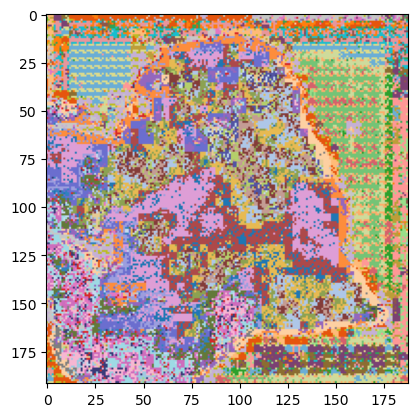

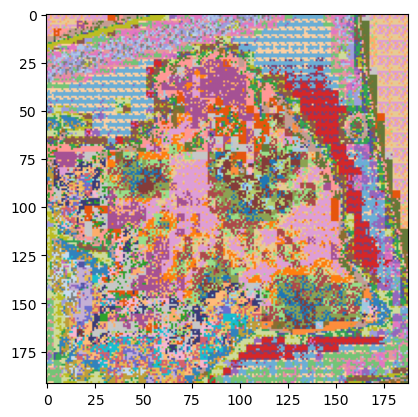

In [51]:
extended = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
for sid, d in sample_to_embs.items():
    x = d['clustered_patches']
    rgb = display_labeled_as_rgb(x, cmap=extended)
    plt.imshow(rgb)
    plt.show()

In [52]:
from pathlib import Path
out_dir = os.path.join(run_dir, 'results')
Path(out_dir).mkdir(parents=True, exist_ok=True)
out_dir

'/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results'

In [53]:
for fp, d in sample_to_embs.items():
    sid = fp.split('/')[-1].split('.')[0]
    torch.save(d, os.path.join(out_dir, f'{sid}_{n_clusters}knn.pt'))

In [84]:
import scanpy as sc

In [85]:
a = sc.read_h5ad('/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s0.h5ad')
a

AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

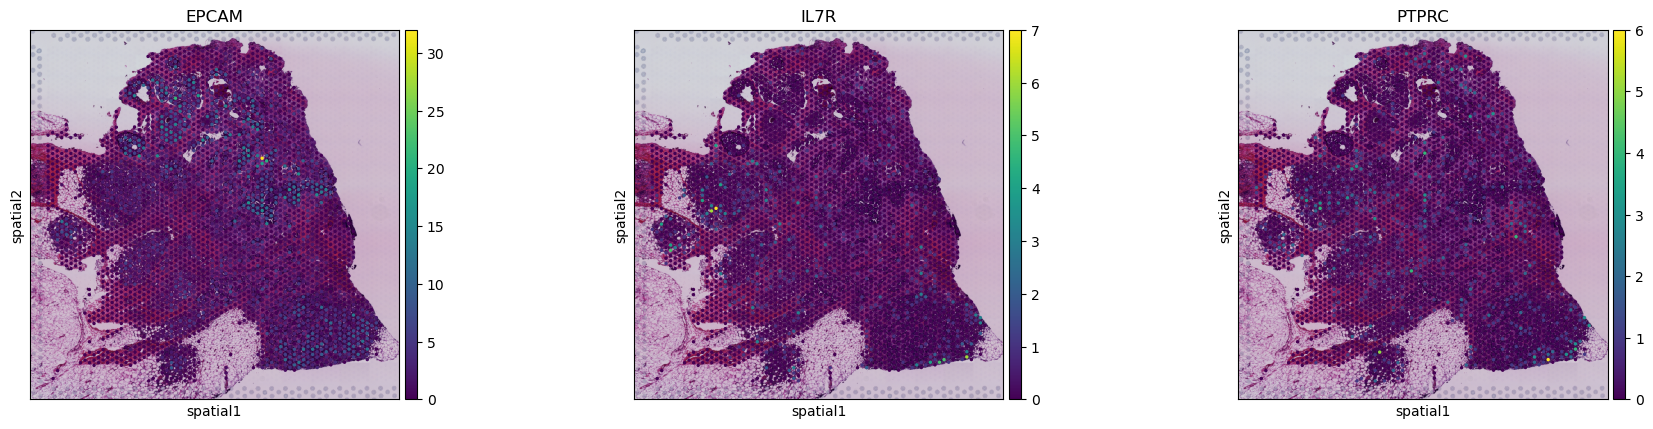

In [87]:
sc.pl.spatial(a, color=['EPCAM', 'IL7R', 'PTPRC'])

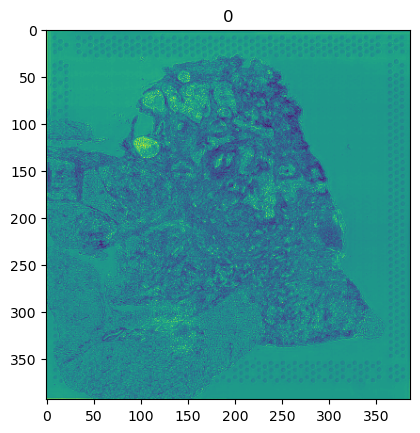

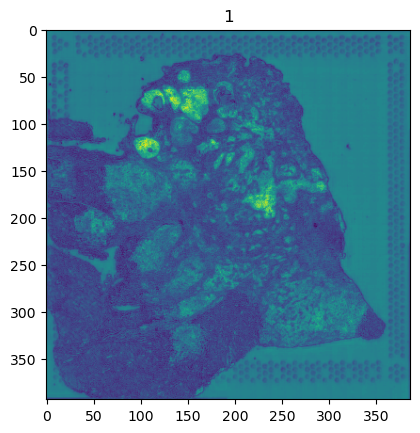

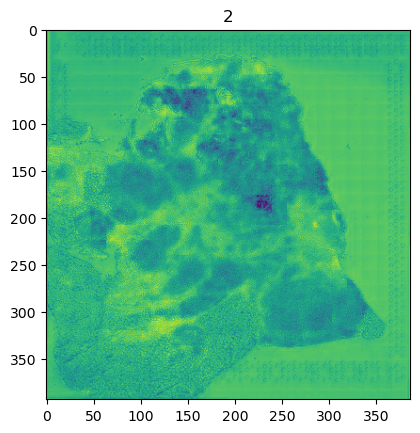

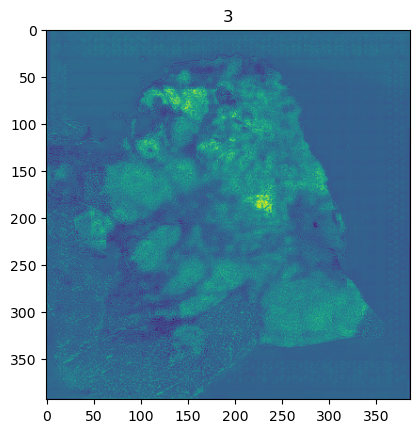

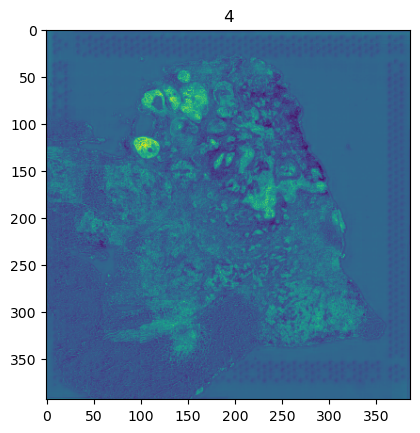

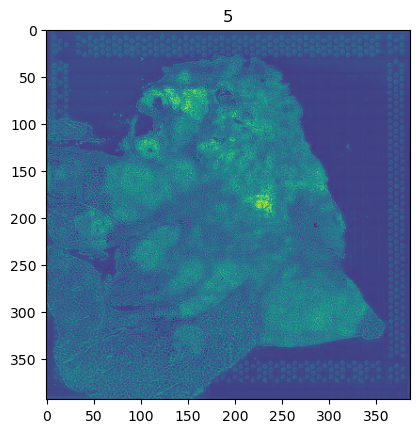

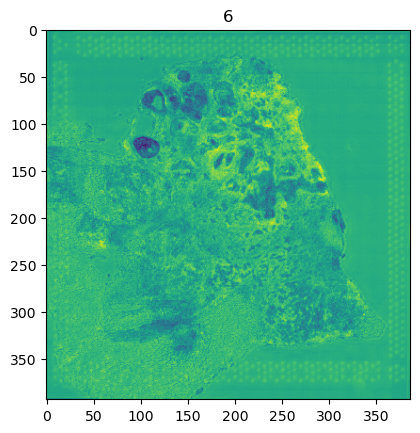

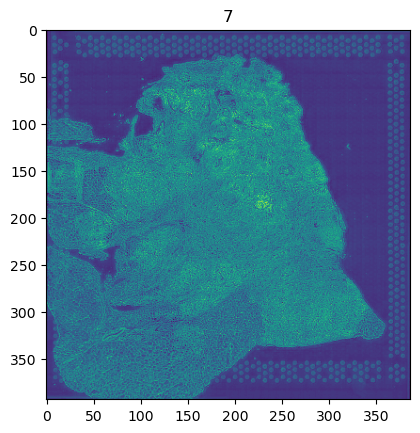

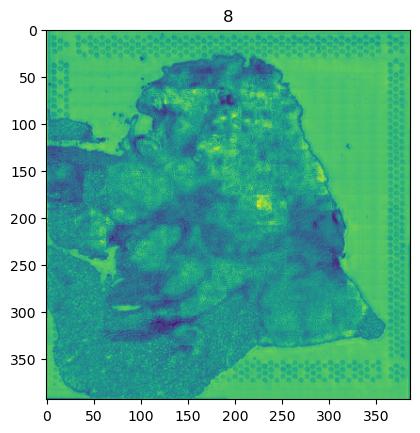

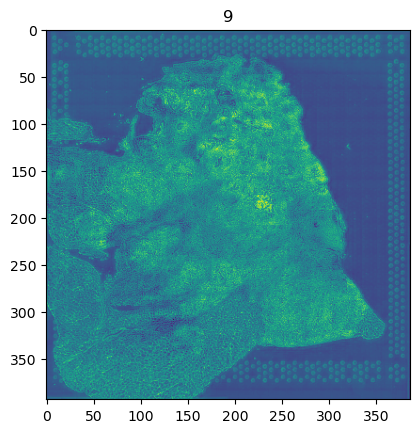

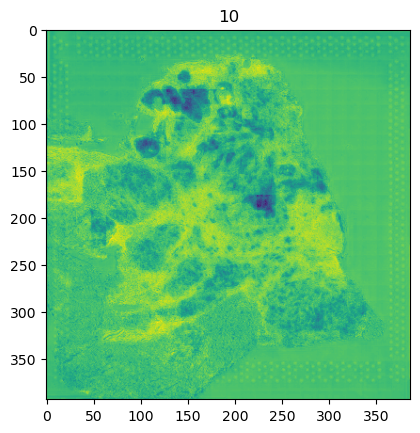

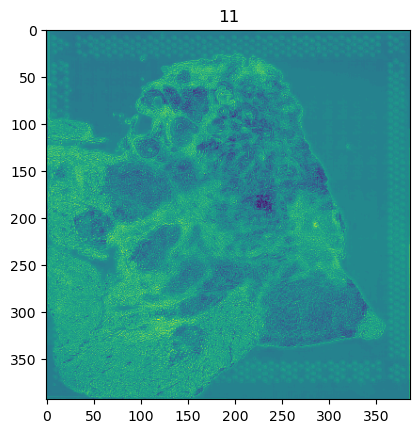

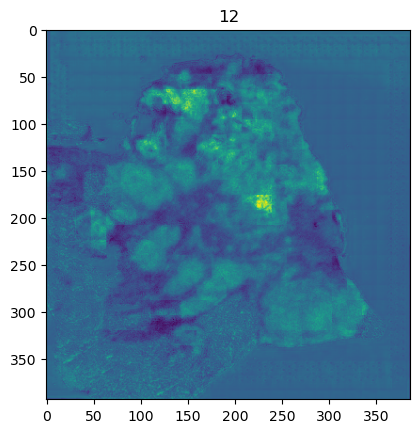

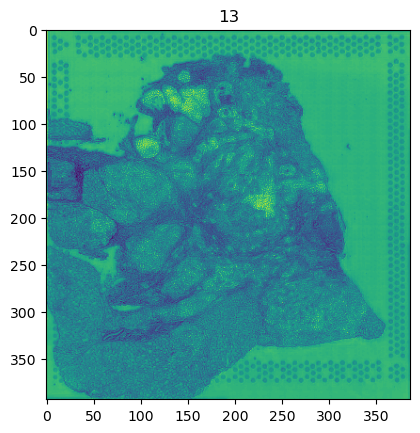

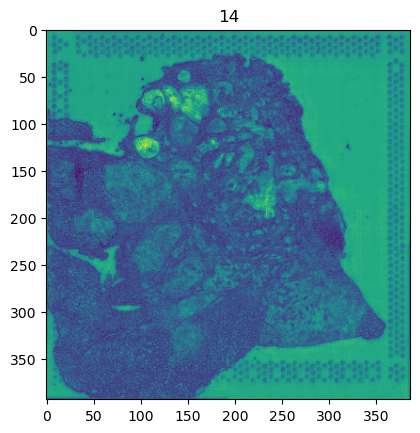

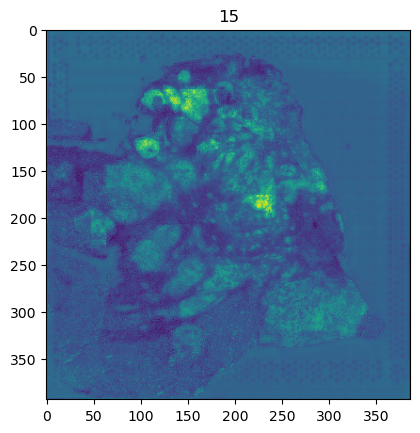

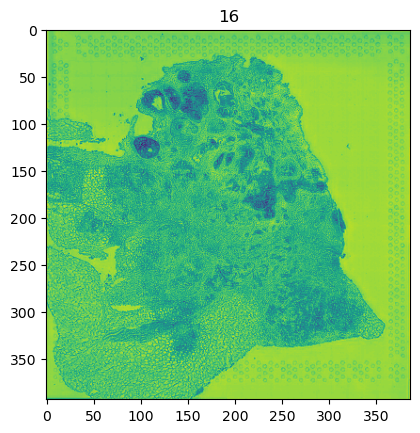

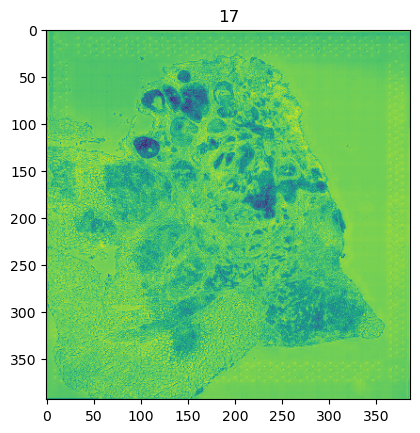

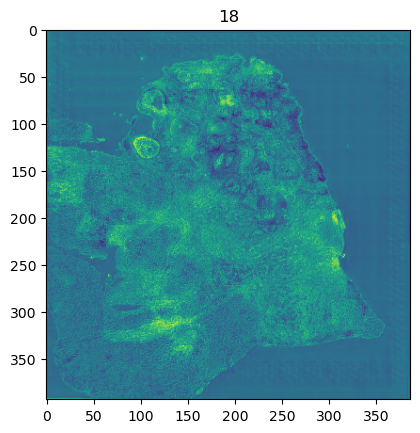

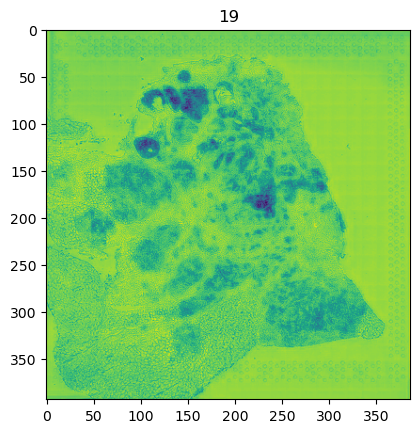

In [89]:
for i in range(n_image_channels):
    plt.imshow(imgs[0][i])
    plt.title(i)
    plt.show()